In [1]:
import numpy as np
import os
import h5py
import random

# Directory containing .h5 files
directory = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Limit dataset size to 5000 samples
h5_files = random.sample(h5_files, 5000)  # Resampling to 5000 files
print(f"Resampled to {len(h5_files)} .h5 files")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    selected_file = random.choice(h5_files)
    file_path = os.path.join(directory, selected_file)
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5']
Resampled to 5000 .h5 files

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 5.901098920107242
Array min val: -0.4015126910098927

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0


## **Visualizing the Data**

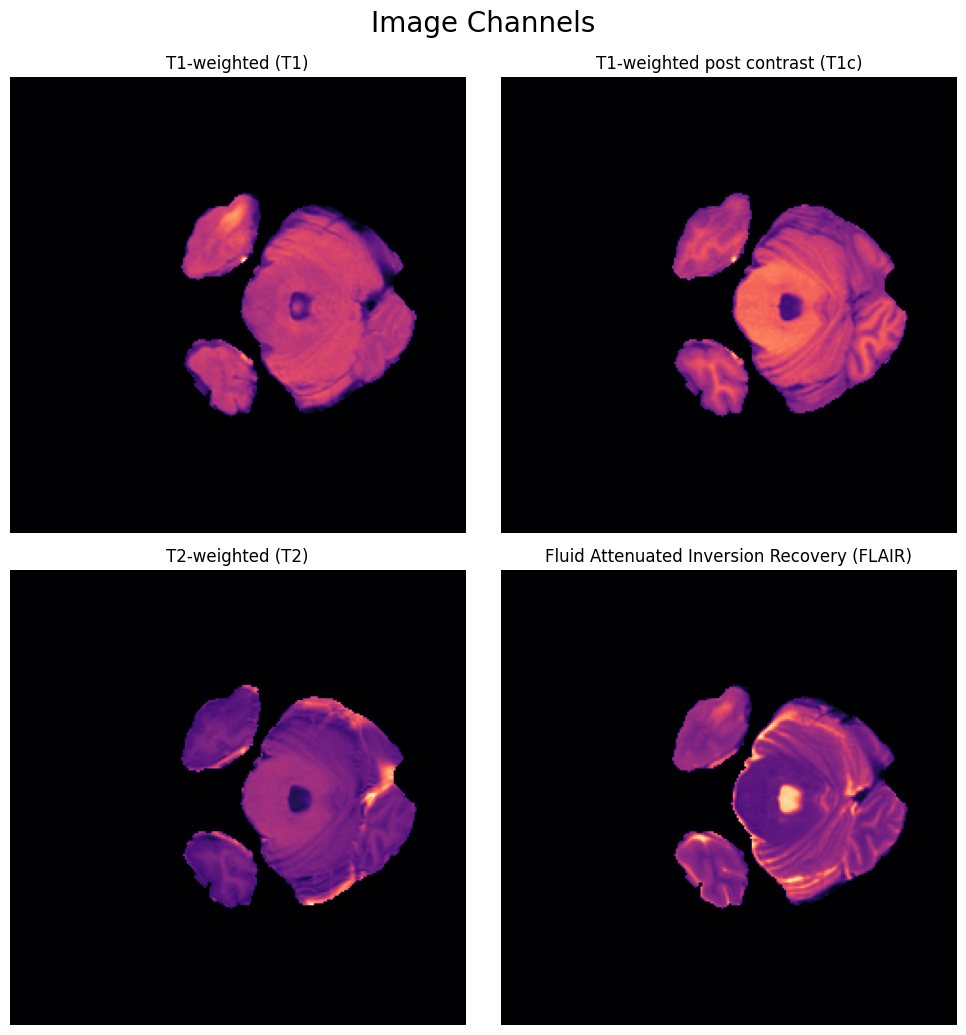

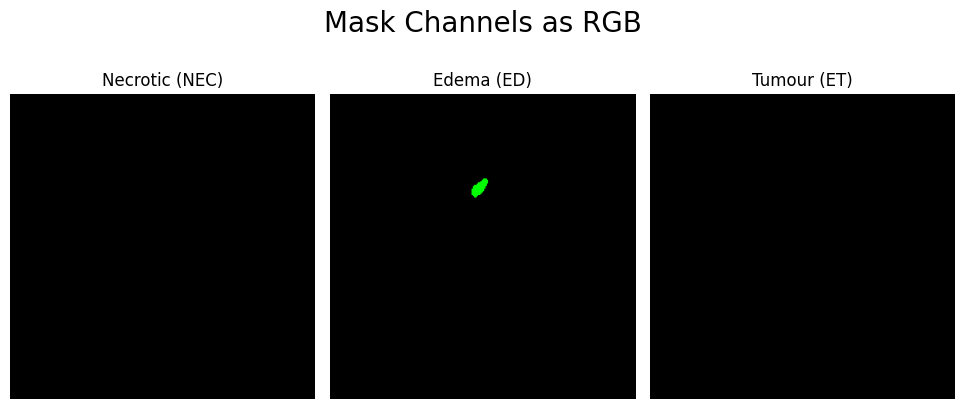

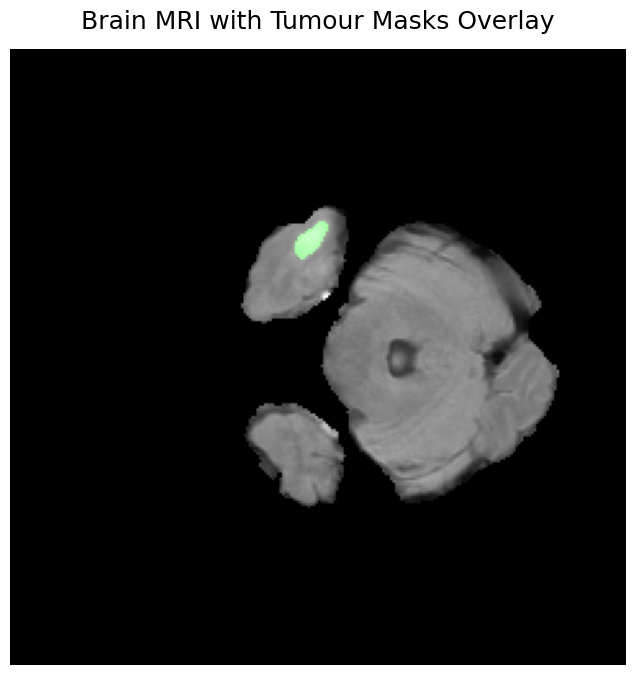

In [2]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# plt.rcParams['figure.facecolor'] = '#171717'
# plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')    
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_selected = random.choice(h5_files)
sample_file_path = os.path.join(directory, sample_selected)
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

## **Dataset Splitting**
### **DataLoader**: The dataloaders are created using the resampled dataset.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                min_val = np.min(image[i])     # Find the min value in the channel
                image[i] = image[i] - min_val  # Shift values to ensure min is 0
                max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
                image[i] = image[i] / max_val
            
            # Convert to float and scale the whole image
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Resampling to 5000 files
h5_files = random.sample(h5_files, 5000)

# Split the dataset into train and validation sets (80:10)
split_idx = int(0.8 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break


Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


In [4]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class BrainScanDataset(Dataset):
#     def __init__(self, file_paths, deterministic=False):
#         self.file_paths = file_paths
#         if deterministic:  # To always generate the same test images for consistency
#             np.random.seed(1)
#         np.random.shuffle(self.file_paths)
        
#     def __len__(self):
#         return len(self.file_paths)
    
#     def __getitem__(self, idx):
#         # Load h5 file, get image and mask
#         file_path = self.file_paths[idx]
#         with h5py.File(file_path, 'r') as file:
#             image = file['image'][()]
#             mask = file['mask'][()]
            
#             # Reshape: (H, W, C) -> (C, H, W)
#             image = image.transpose((2, 0, 1))
#             mask = mask.transpose((2, 0, 1))
            
#             # Adjusting pixel values for each channel in the image so they are between 0 and 255
#             for i in range(image.shape[0]):    # Iterate over channels
#                 min_val = np.min(image[i])     # Find the min value in the channel
#                 image[i] = image[i] - min_val  # Shift values to ensure min is 0
#                 max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
#                 image[i] = image[i] / max_val
            
#             # Convert to float and scale the whole image
#             image = torch.tensor(image, dtype=torch.float32)
#             mask = torch.tensor(mask, dtype=torch.float32) 
            
#         return image, mask

# # Build .h5 file paths from directory containing .h5 files
# h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
# np.random.seed(42)
# np.random.shuffle(h5_files)

# # Split the dataset into train and validation sets (80:10)
# split_idx = int(0.8 * len(h5_files))
# train_files = h5_files[:split_idx]
# val_files = h5_files[split_idx:]

# # Create the train and val datasets
# train_dataset = BrainScanDataset(train_files)
# val_dataset = BrainScanDataset(val_files, deterministic=True)

# # Sample dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# # Use this to generate test images to view later
# test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=True))

# # Verifying dataloaders work
# for images, masks in train_dataloader:
#     print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
#     break
# for images, masks in val_dataloader:
#     print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
#     break

## Define the model **SimpleCNN** 

In [4]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)  # 4 input channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16 input channels, 32 output channels
        # Compute the flattened size after the convolutions
        self.flattened_size = 32 * 240 * 240  # 32 channels, 240x240 spatial dimensions
        self.fc1 = nn.Linear(self.flattened_size, 128)  # Flattened to 128 units
        self.fc2 = nn.Linear(128, 1)  # For binary classification

    def forward(self, x):
        # Apply convolutional layers with ReLU activation
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor to a vector
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits (for binary classification)
        return x


## **Define Encoder Decoder Blocks**

In [26]:
from torch import nn

def encoder_block(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

def decoder_block(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

### **Unet** Model Architecture

In [27]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU()):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block(in_channels, 1 * n_filters, activation)
        self.enc2 = encoder_block(1 * n_filters, 2 * n_filters, activation)
        self.enc3 = encoder_block(2 * n_filters, 4 * n_filters, activation)
        self.enc4 = encoder_block(4 * n_filters, 8 * n_filters, activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8 * n_filters, 16 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Conv2d(16 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec4 = decoder_block(16 * n_filters, 4 * n_filters, activation)
        self.dec3 = decoder_block(8 * n_filters, 2 * n_filters, activation)
        self.dec2 = decoder_block(4 * n_filters, 1 * n_filters, activation)
        self.dec1 = decoder_block(2 * n_filters, 1 * n_filters, activation)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder pathway with skip connections
        dec4 = self.dec4(torch.cat([self.upsample(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upsample(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

## **Save model and count parameters**

In [28]:
def count_parameters(model):
    """
    Counts and prints the number of trainable parameters in the model.
    
    Parameters:
    - model (nn.Module): The neural network model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total Parameters: {total_params:,}\n')

def save_model(model, path='model_weights.pth'):
    """
    Saves the model's state dictionary to the specified path.
    
    Parameters:
    - model (nn.Module): The neural network model.
    - path (str): File path to save the model weights.
    """
    torch.save(model.state_dict(), path)

## **Training Configuration**

In [29]:
# train_config = {
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu',
#     'n_epochs': 10,  # Reduced number of epochs
#     'batch_size': 64,
#     'learning_rate': 0.001,
#     'batches_per_epoch': 64,
#     'lr_decay_factor': 1,
#     'optimizer_type': 'Adam'
# }

# # Instantiate the model
# activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu


In [6]:
# Cell 2: Define Configuration Dictionary

train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'n_epochs': 10,  # Set your number of epochs
    'learning_rate': 0.001,  # Set your learning rate
    'batches_per_epoch': 100,  # Set your desired number of batches per epoch
    'lr_decay_factor': 0.9,  # Learning rate decay factor
}


In [7]:
# ## Previous Code

# train_config = {
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu',
#     'n_epochs':          20,
#     'batch_size':        64,
#     'learning_rate':     0.001,
#     'batches_per_epoch': 64,
#     'lr_decay_factor':   1,
#     'optimizer_type': 'Adam'
# }

# # Instantiate the model
# activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
# model = UNet(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# # Count parameters
# count_parameters(model)

# # Move model to device
# device = torch.device(train_config['device'])
# model = model.to(device)

## Helper function for metrics **Dice Coefficient, Precision, Recall, Accuracy**

In [11]:
import torch
import torch.nn as nn

# Dice Coefficient
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    intersection = (preds * targets).sum()
    dice = (2.0 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice.item()

# Precision
def calculate_precision(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    predicted_positives = preds.sum()

    precision_value = (true_positives + smooth) / (predicted_positives + smooth)
    return precision_value.item()

# Recall
def calculate_recall(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    actual_positives = targets.sum()

    recall_value = (true_positives + smooth) / (actual_positives + smooth)
    return recall_value.item()

# Accuracy
def calculate_accuracy(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    correct = (preds == targets).float().sum()
    total = targets.numel()

    accuracy_value = correct / total
    return accuracy_value.item()


In [33]:
# def dice_coefficient(preds, targets, smooth=1e-6):
#     """
#     Computes the Dice coefficient between predictions and targets.
    
#     Args:
#     - preds (torch.Tensor): The predicted output from the model (logits).
#     - targets (torch.Tensor): The ground truth binary masks.
#     - smooth (float): Smoothing factor to avoid division by zero.
    
#     Returns:
#     - dice (float): The Dice coefficient for the batch.
#     """
#     # Apply sigmoid to the predicted logits
#     preds = torch.sigmoid(preds)
    
#     # Threshold to get binary predictions (0 or 1)
#     preds = (preds > 0.5).float()
    
#     # Flatten tensors to 1D for all the pixels in the batch
#     preds = preds.view(-1)
#     targets = targets.view(-1)
    
#     # Compute the intersection and union
#     intersection = (preds * targets).sum()
#     dice = (2.0 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
#     return dice.item()

In [34]:
# def calculate_precision(preds, targets, smooth=1e-6):
#     """
#     Computes precision between predictions and targets.
#     """
#     preds = torch.sigmoid(preds)
#     preds = (preds > 0.5).float()
#     preds = preds.view(-1)
#     targets = targets.view(-1)

#     true_positives = (preds * targets).sum()
#     predicted_positives = preds.sum()

#     precision_value = (true_positives + smooth) / (predicted_positives + smooth)
#     return precision_value.item()

In [35]:
# def calculate_recall(preds, targets, smooth=1e-6):
#     """
#     Computes recall between predictions and targets.
#     """
#     preds = torch.sigmoid(preds)
#     preds = (preds > 0.5).float()
#     preds = preds.view(-1)
#     targets = targets.view(-1)

#     true_positives = (preds * targets).sum()
#     actual_positives = targets.sum()

#     recall_value = (true_positives + smooth) / (actual_positives + smooth)
#     return recall_value.item()

In [36]:
# def calculate_accuracy(preds, targets):
#     """
#     Computes accuracy between predictions and targets.
#     """
#     preds = torch.sigmoid(preds)
#     preds = (preds > 0.5).float()
#     preds = preds.view(-1)
#     targets = targets.view(-1)

#     correct = (preds == targets).float().sum()
#     total = targets.numel()

#     accuracy_value = correct / total
#     return accuracy_value.item()

## **Train with configurable optimizer and batch size**

In [37]:
def train_with_diff_configs(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']
    optimizer_type = config['optimizer_type']

    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()

    if optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    elif optimizer_type == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optimizer_type == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optimizer_type == 'Nadam':
        optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    train_epoch_losses = []
    val_epoch_losses = []

    print(f"Training with {optimizer_type} optimizer...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        total_dice, total_precision, total_recall, total_accuracy = 0, 0, 0, 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: 
                print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            
            # Forward pass
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            # Calculate metrics
            dice_score = dice_coefficient(train_preds, train_targets)
            precision = calculate_precision(train_preds, train_targets)
            recall = calculate_recall(train_preds, train_targets)
            accuracy = calculate_accuracy(train_preds, train_targets)

            total_dice += dice_score
            total_precision += precision
            total_recall += recall
            total_accuracy += accuracy

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break

        # Average metrics for the epoch
        avg_train_loss = train_epoch_loss / batches_per_epoch
        avg_dice = total_dice / batches_per_epoch
        avg_precision = total_precision / batches_per_epoch
        avg_recall = total_recall / batches_per_epoch
        avg_accuracy = total_accuracy / batches_per_epoch

        print(f"\nEpoch {epoch}/{n_epochs}:")
        print(f"Training Loss: {avg_train_loss:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

        train_epoch_losses.append(avg_train_loss)

        # Validation step
        avg_val_loss, avg_val_dice, avg_val_precision, avg_val_recall, avg_val_accuracy = validate_model(model, val_dataloader, loss_fn, device)
        print(f"Validation Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, Accuracy: {avg_val_accuracy:.4f}")
        val_epoch_losses.append(avg_val_loss)

    return train_epoch_losses, val_epoch_losses


## **Define the validation function**

In [38]:
def validate_model(model, val_dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    accuracy_total = 0.0
    n_batches = len(val_dataloader)

    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)

            # Forward pass
            val_preds = model(val_inputs)

            # Loss calculation
            loss = loss_fn(val_preds, val_targets)
            val_loss += loss.item()

            # Metric calculations
            dice_total += dice_coefficient(val_preds, val_targets)
            precision_total += calculate_precision(val_preds, val_targets)
            recall_total += calculate_recall(val_preds, val_targets)
            accuracy_total += calculate_accuracy(val_preds, val_targets)

    val_loss /= n_batches
    dice_total /= n_batches
    precision_total /= n_batches
    recall_total /= n_batches
    accuracy_total /= n_batches

    return val_loss, dice_total, precision_total, recall_total, accuracy_total


In [39]:
# def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
#     device = config['device']
#     n_epochs = config['n_epochs']
#     learning_rate = config['learning_rate']
#     batches_per_epoch = config['batches_per_epoch']
#     lr_decay_factor = config['lr_decay_factor']
#     optimizer_type = config['optimizer_type']

#     # model.to(device)
#     # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     # loss_fn = nn.BCEWithLogitsLoss()
#     model.to(device)
#     loss_fn = nn.BCEWithLogitsLoss()

#     if optimizer_type == 'Adam':
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     elif optimizer_type == 'SGD':
#         optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
#     elif optimizer_type == 'RMSprop':
#         optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     elif optimizer_type == 'Adagrad':
#         optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     elif optimizer_type == 'Nadam':
#         optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     else:
#         raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
#     train_epoch_losses = []
#     val_epoch_losses = []
    
#     print("Training...")
#     for epoch in range(1, n_epochs + 1):
#         # Decay learning rate
#         current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = current_lr

#         # Training step
#         model.train()
#         train_epoch_loss = 0
#         total_dice, total_precision, total_recall, total_accuracy = 0, 0, 0, 0
#         for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
#             if verbose: 
#                 print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            
#             train_inputs = train_inputs.to(device)
#             train_targets = train_targets.to(device)
            
#             # Forward pass
#             train_preds = model(train_inputs)
#             train_batch_loss = loss_fn(train_preds, train_targets)
#             train_epoch_loss += train_batch_loss.item()

#             optimizer.zero_grad()
#             train_batch_loss.backward()
#             optimizer.step()

#             # Calculate metrics
#             dice_score = dice_coefficient(train_preds, train_targets)
#             precision = calculate_precision(train_preds, train_targets)
#             recall = calculate_recall(train_preds, train_targets)
#             accuracy = calculate_accuracy(train_preds, train_targets)

#             total_dice += dice_score
#             total_precision += precision
#             total_recall += recall
#             total_accuracy += accuracy

#             if train_batch_idx >= batches_per_epoch:
#                 if verbose: print()
#                 break

#         # Average metrics for the epoch
#         avg_train_loss = train_epoch_loss / batches_per_epoch
#         avg_dice = total_dice / batches_per_epoch
#         avg_precision = total_precision / batches_per_epoch
#         avg_recall = total_recall / batches_per_epoch
#         avg_accuracy = total_accuracy / batches_per_epoch

#         print(f"\nEpoch {epoch}/{n_epochs}:")
#         print(f"Training Loss: {avg_train_loss:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

#         train_epoch_losses.append(avg_train_loss)

#         # Validation step
#         avg_val_loss, avg_val_dice, avg_val_precision, avg_val_recall, avg_val_accuracy = validate_model(model, val_dataloader, loss_fn, device)
#         print(f"Validation Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, Accuracy: {avg_val_accuracy:.4f}")
#         val_epoch_losses.append(avg_val_loss)

#     return train_epoch_losses, val_epoch_losses


# def validate_model(model, val_dataloader, loss_fn, device):
#     """
#     Validates the model on the validation dataset and calculates performance metrics.

#     Parameters:
#     - model (torch.nn.Module): The model to validate.
#     - val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
#     - loss_fn (torch.nn.Module): Loss function used for validation.
#     - device (str): The device to run the validation on ('cpu' or 'cuda').

#     Returns:
#     - val_loss (float): Average validation loss for the epoch.
#     - dice (float): Average Dice coefficient for the epoch.
#     - precision (float): Average precision for the epoch.
#     - recall (float): Average recall for the epoch.
#     - accuracy (float): Average accuracy for the epoch.
#     """
#     model.eval()
#     val_loss = 0.0
#     dice_total = 0.0
#     precision_total = 0.0
#     recall_total = 0.0
#     accuracy_total = 0.0
#     n_batches = len(val_dataloader)

#     with torch.no_grad():  # Disable gradient calculation for validation
#         for val_inputs, val_targets in val_dataloader:
#             val_inputs = val_inputs.to(device)
#             val_targets = val_targets.to(device)

#             # Forward pass
#             val_preds = model(val_inputs)

#             # Loss calculation
#             loss = loss_fn(val_preds, val_targets)
#             val_loss += loss.item()

#             # Metric calculations
#             dice_total += dice_coefficient(val_preds, val_targets)
#             precision_total += calculate_precision(val_preds, val_targets)
#             recall_total += calculate_recall(val_preds, val_targets)
#             accuracy_total += calculate_accuracy(val_preds, val_targets)

#     # Calculate average values for the metrics
#     val_loss /= n_batches
#     dice_total /= n_batches
#     precision_total /= n_batches
#     recall_total /= n_batches
#     accuracy_total /= n_batches

#     return val_loss, dice_total, precision_total, recall_total, accuracy_total

# **Test**


Running experiment with optimizer: Adam, batch size: 8
Epoch 1/10 | Train Loss: 0.0434 | Validation Loss: 0.0216
Epoch 2/10 | Train Loss: 0.0217 | Validation Loss: 0.0215
Epoch 3/10 | Train Loss: 0.0211 | Validation Loss: 0.0214
Epoch 4/10 | Train Loss: 0.0209 | Validation Loss: 0.0215
Epoch 5/10 | Train Loss: 0.0206 | Validation Loss: 0.0212
Epoch 6/10 | Train Loss: 0.0205 | Validation Loss: 0.0216
Epoch 7/10 | Train Loss: 0.0205 | Validation Loss: 0.0214
Epoch 8/10 | Train Loss: 0.0203 | Validation Loss: 0.0213
Epoch 9/10 | Train Loss: 0.0203 | Validation Loss: 0.0219
Epoch 10/10 | Train Loss: 0.0202 | Validation Loss: 0.0212


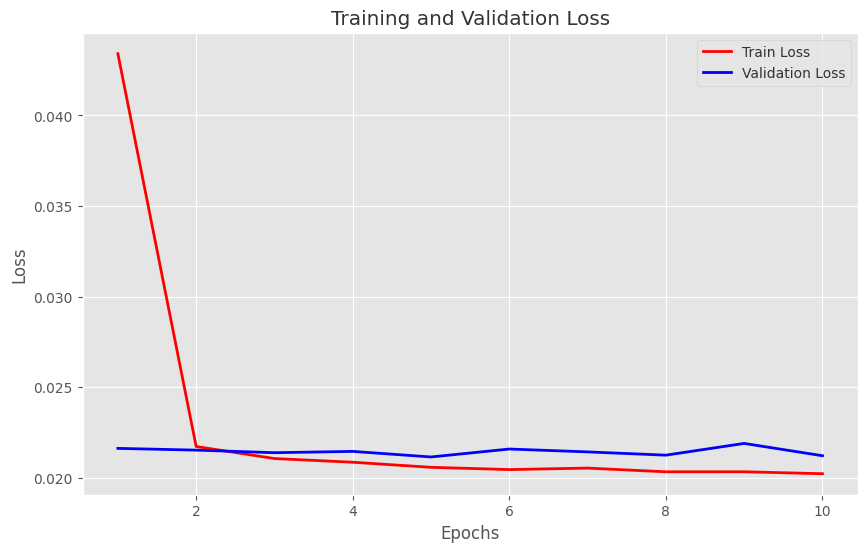


Running experiment with optimizer: Adam, batch size: 16
Epoch 1/10 | Train Loss: 0.0203 | Validation Loss: 0.0213
Epoch 2/10 | Train Loss: 0.0200 | Validation Loss: 0.0211
Epoch 3/10 | Train Loss: 0.0200 | Validation Loss: 0.0212
Epoch 4/10 | Train Loss: 0.0200 | Validation Loss: 0.0212
Epoch 5/10 | Train Loss: 0.0199 | Validation Loss: 0.0209
Epoch 6/10 | Train Loss: 0.0199 | Validation Loss: 0.0212
Epoch 7/10 | Train Loss: 0.0199 | Validation Loss: 0.0214
Epoch 8/10 | Train Loss: 0.0198 | Validation Loss: 0.0211
Epoch 9/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 10/10 | Train Loss: 0.0197 | Validation Loss: 0.0214


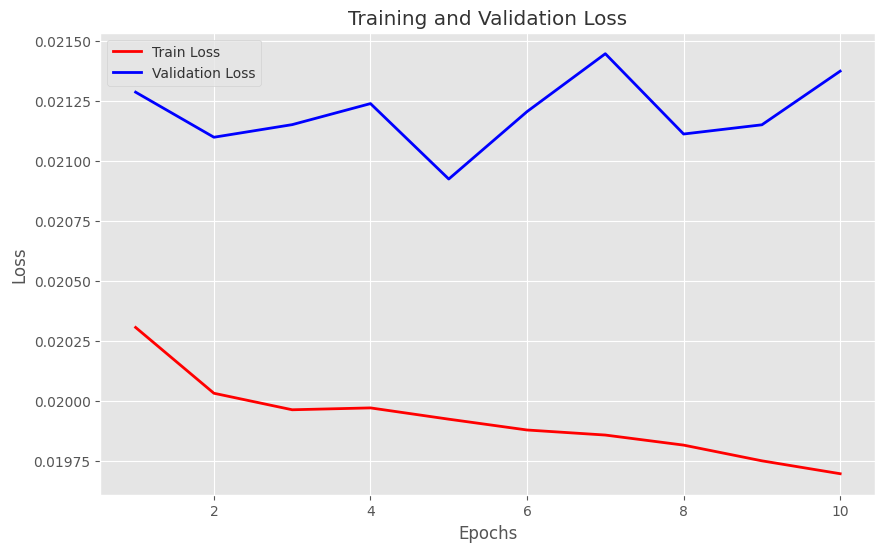


Running experiment with optimizer: Adam, batch size: 32
Epoch 1/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 2/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 3/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 4/10 | Train Loss: 0.0197 | Validation Loss: 0.0210
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0211
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0211
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0210
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0210
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0209
Epoch 10/10 | Train Loss: 0.0197 | Validation Loss: 0.0209


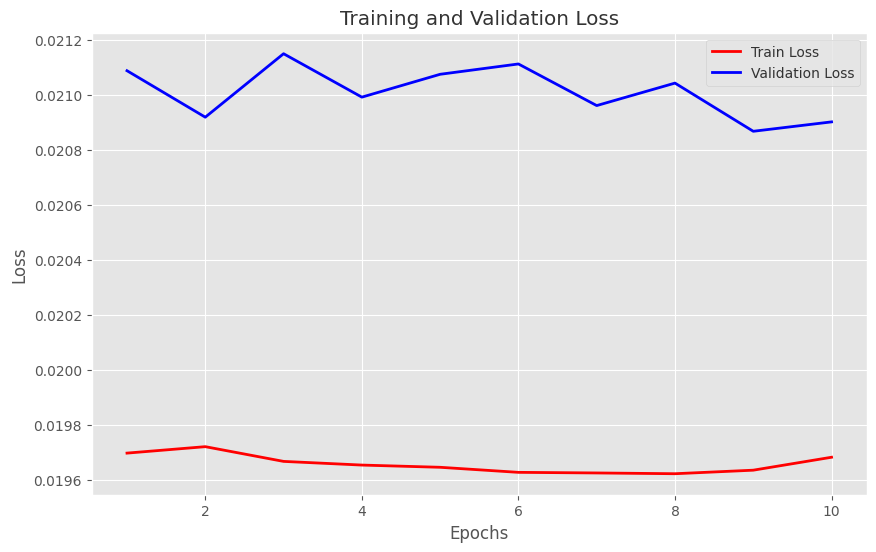


Running experiment with optimizer: SGD, batch size: 8
Epoch 1/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 2/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 3/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 4/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 5/10 | Train Loss: 0.0197 | Validation Loss: 0.0214
Epoch 6/10 | Train Loss: 0.0197 | Validation Loss: 0.0213
Epoch 7/10 | Train Loss: 0.0197 | Validation Loss: 0.0213
Epoch 8/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 9/10 | Train Loss: 0.0197 | Validation Loss: 0.0212
Epoch 10/10 | Train Loss: 0.0197 | Validation Loss: 0.0213


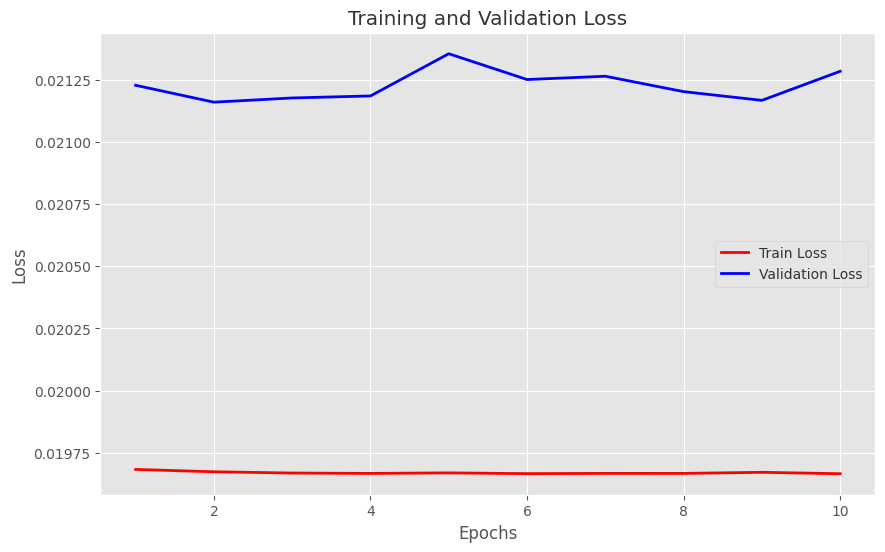


Running experiment with optimizer: SGD, batch size: 16
Epoch 1/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 2/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 3/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 4/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 5/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 6/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 7/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 8/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 9/10 | Train Loss: 0.0197 | Validation Loss: 0.0211
Epoch 10/10 | Train Loss: 0.0197 | Validation Loss: 0.0211


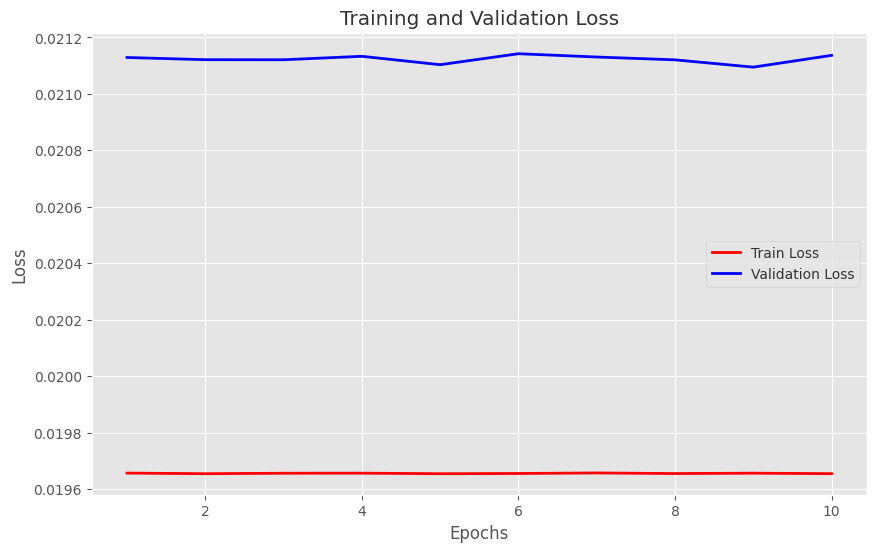


Running experiment with optimizer: SGD, batch size: 32
Epoch 1/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 2/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 3/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 4/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 5/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 6/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 7/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 8/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 9/10 | Train Loss: 0.0197 | Validation Loss: 0.0209
Epoch 10/10 | Train Loss: 0.0197 | Validation Loss: 0.0209


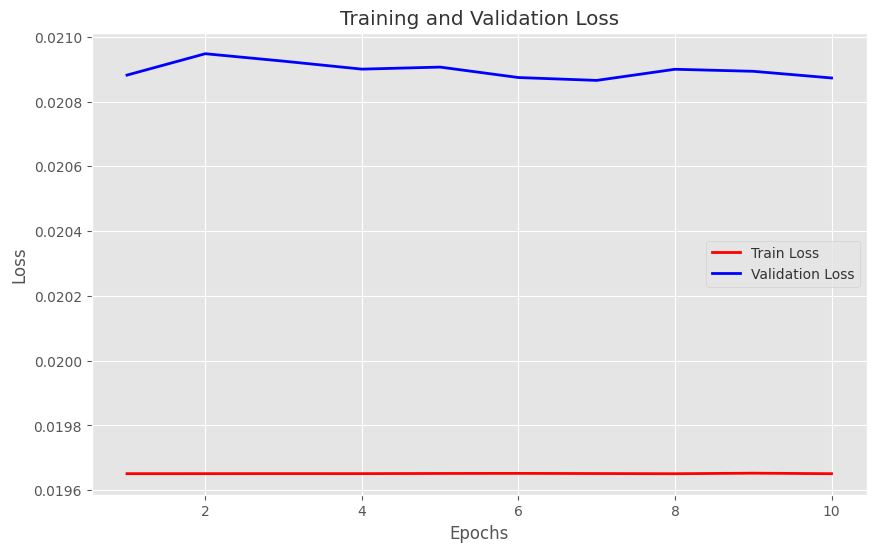


Running experiment with optimizer: RMSprop, batch size: 8
Epoch 1/10 | Train Loss: 10.6282 | Validation Loss: 3.1001
Epoch 2/10 | Train Loss: 0.8096 | Validation Loss: 0.0234
Epoch 3/10 | Train Loss: 0.0242 | Validation Loss: 0.0232
Epoch 4/10 | Train Loss: 0.0247 | Validation Loss: 0.0230
Epoch 5/10 | Train Loss: 6.7038 | Validation Loss: 0.0358
Epoch 6/10 | Train Loss: 0.0241 | Validation Loss: 0.0238
Epoch 7/10 | Train Loss: 0.0223 | Validation Loss: 0.0227
Epoch 8/10 | Train Loss: 0.0220 | Validation Loss: 0.0227
Epoch 9/10 | Train Loss: 0.0216 | Validation Loss: 0.0233
Epoch 10/10 | Train Loss: 0.1610 | Validation Loss: 0.0229


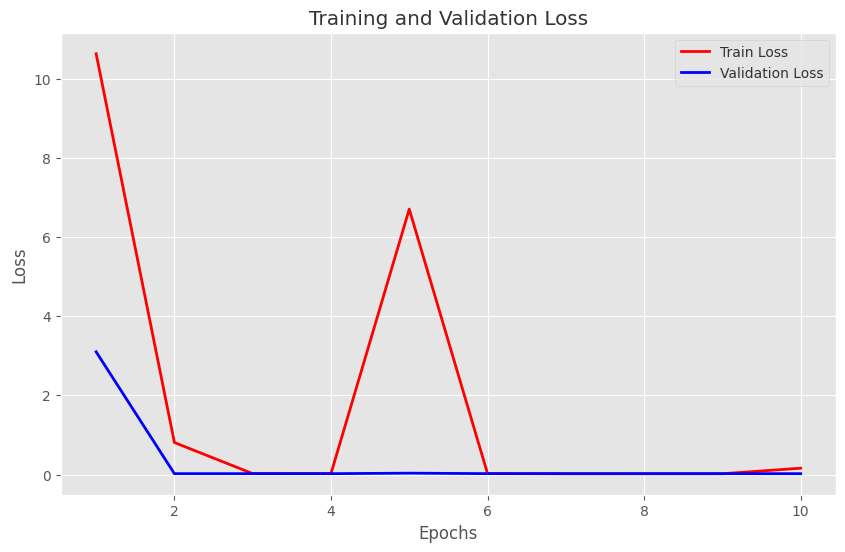


Running experiment with optimizer: RMSprop, batch size: 16
Epoch 1/10 | Train Loss: 5.8415 | Validation Loss: 0.0537
Epoch 2/10 | Train Loss: 0.0300 | Validation Loss: 0.0229
Epoch 3/10 | Train Loss: 0.0222 | Validation Loss: 0.0226
Epoch 4/10 | Train Loss: 0.0217 | Validation Loss: 0.0226
Epoch 5/10 | Train Loss: 0.0226 | Validation Loss: 0.0226
Epoch 6/10 | Train Loss: 0.0214 | Validation Loss: 0.0232
Epoch 7/10 | Train Loss: 0.0209 | Validation Loss: 0.0228
Epoch 8/10 | Train Loss: 0.0241 | Validation Loss: 0.0232
Epoch 9/10 | Train Loss: 0.0212 | Validation Loss: 0.0226
Epoch 10/10 | Train Loss: 0.0203 | Validation Loss: 0.0227


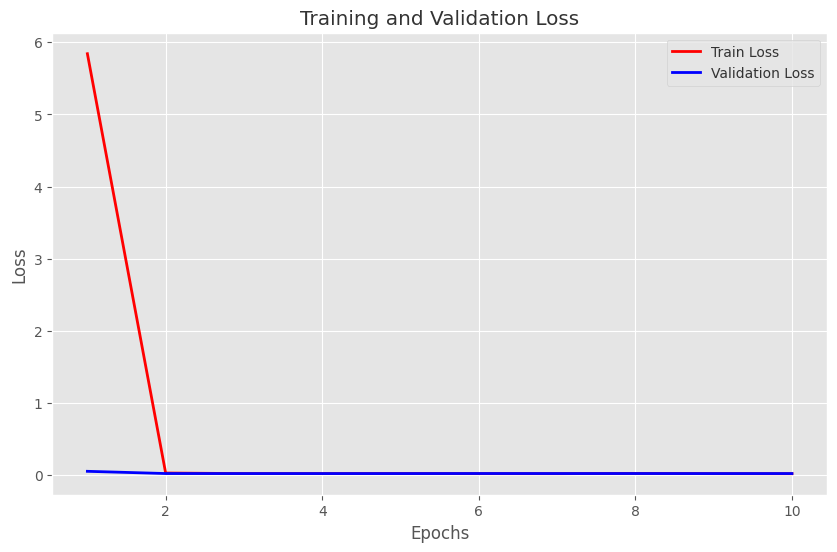


Running experiment with optimizer: RMSprop, batch size: 32
Epoch 1/10 | Train Loss: 0.0861 | Validation Loss: 0.0231
Epoch 2/10 | Train Loss: 0.0208 | Validation Loss: 0.0233
Epoch 3/10 | Train Loss: 0.0203 | Validation Loss: 0.0227
Epoch 4/10 | Train Loss: 0.0201 | Validation Loss: 0.0228
Epoch 5/10 | Train Loss: 0.0200 | Validation Loss: 0.0228
Epoch 6/10 | Train Loss: 0.0201 | Validation Loss: 0.0234
Epoch 7/10 | Train Loss: 0.0200 | Validation Loss: 0.0228
Epoch 8/10 | Train Loss: 0.0199 | Validation Loss: 0.0232
Epoch 9/10 | Train Loss: 0.0199 | Validation Loss: 0.0231
Epoch 10/10 | Train Loss: 0.0199 | Validation Loss: 0.0233


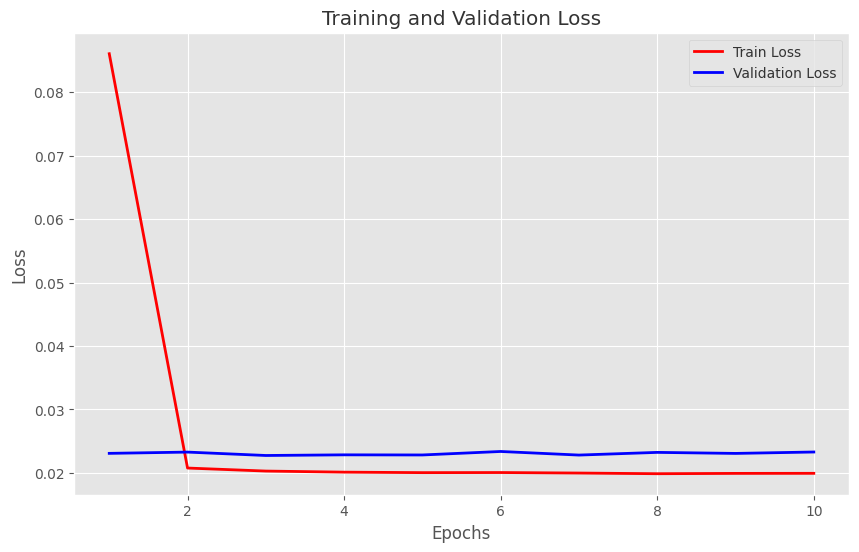


Running experiment with optimizer: Adagrad, batch size: 8
Epoch 1/10 | Train Loss: 0.0198 | Validation Loss: 0.0238
Epoch 2/10 | Train Loss: 0.0197 | Validation Loss: 0.0239
Epoch 3/10 | Train Loss: 0.0197 | Validation Loss: 0.0240
Epoch 4/10 | Train Loss: 0.0197 | Validation Loss: 0.0241
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0243
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0245
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0247
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0249
Epoch 10/10 | Train Loss: 0.0196 | Validation Loss: 0.0251


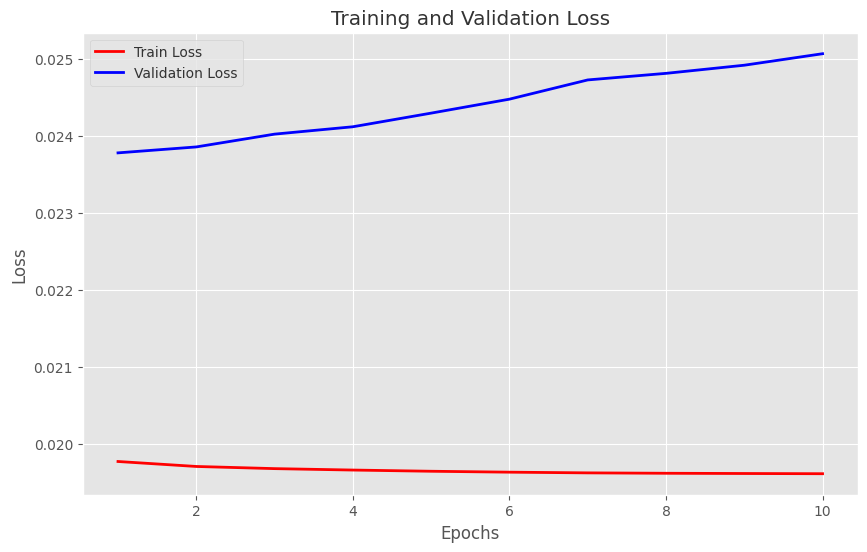


Running experiment with optimizer: Adagrad, batch size: 16
Epoch 1/10 | Train Loss: 0.0196 | Validation Loss: 0.0251
Epoch 2/10 | Train Loss: 0.0196 | Validation Loss: 0.0249
Epoch 3/10 | Train Loss: 0.0196 | Validation Loss: 0.0252
Epoch 4/10 | Train Loss: 0.0196 | Validation Loss: 0.0252
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0254
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0255
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0256
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0256
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0257
Epoch 10/10 | Train Loss: 0.0196 | Validation Loss: 0.0258


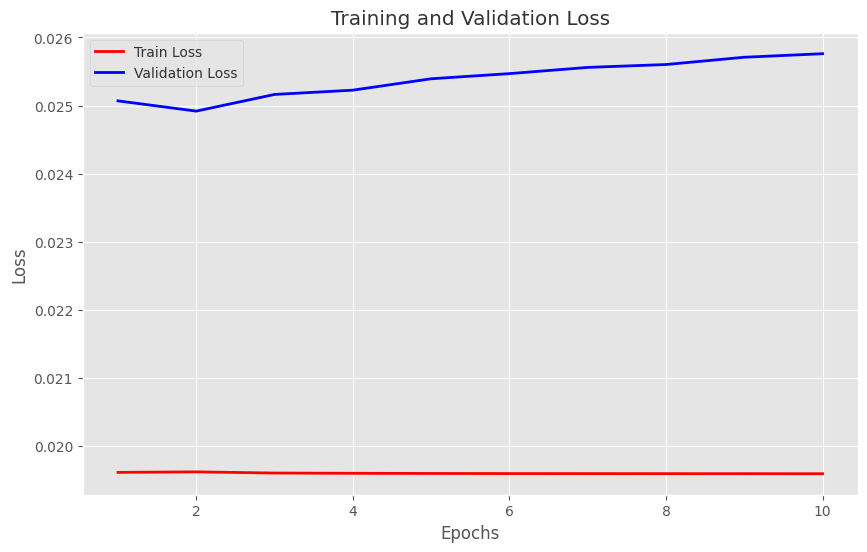


Running experiment with optimizer: Adagrad, batch size: 32
Epoch 1/10 | Train Loss: 0.0196 | Validation Loss: 0.0257
Epoch 2/10 | Train Loss: 0.0196 | Validation Loss: 0.0253
Epoch 3/10 | Train Loss: 0.0196 | Validation Loss: 0.0256
Epoch 4/10 | Train Loss: 0.0196 | Validation Loss: 0.0257
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0257
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0258
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0259
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0260
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0260
Epoch 10/10 | Train Loss: 0.0196 | Validation Loss: 0.0261


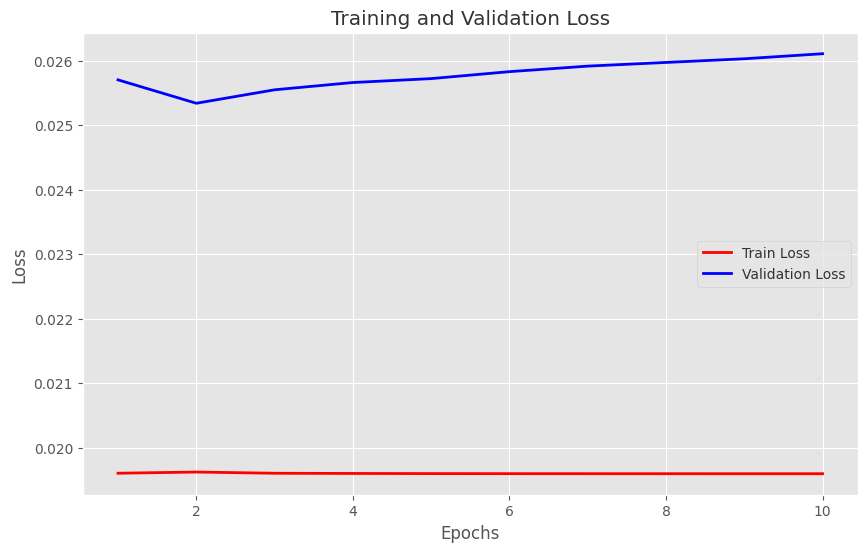


Running experiment with optimizer: Nadam, batch size: 8
Epoch 1/10 | Train Loss: 0.0196 | Validation Loss: 0.0255
Epoch 2/10 | Train Loss: 0.0197 | Validation Loss: 0.0251
Epoch 3/10 | Train Loss: 0.0197 | Validation Loss: 0.0249
Epoch 4/10 | Train Loss: 0.0197 | Validation Loss: 0.0245
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0245
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0249
Epoch 10/10 | Train Loss: 0.0196 | Validation Loss: 0.0242


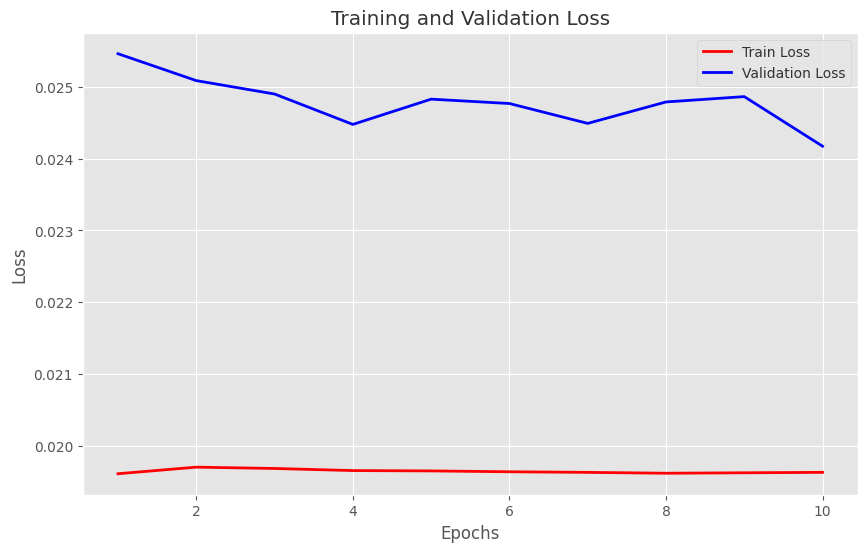


Running experiment with optimizer: Nadam, batch size: 16
Epoch 1/10 | Train Loss: 0.0196 | Validation Loss: 0.0247
Epoch 2/10 | Train Loss: 0.0196 | Validation Loss: 0.0246
Epoch 3/10 | Train Loss: 0.0196 | Validation Loss: 0.0249
Epoch 4/10 | Train Loss: 0.0196 | Validation Loss: 0.0246
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0250
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0249
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0250
Epoch 10/10 | Train Loss: 0.0196 | Validation Loss: 0.0244


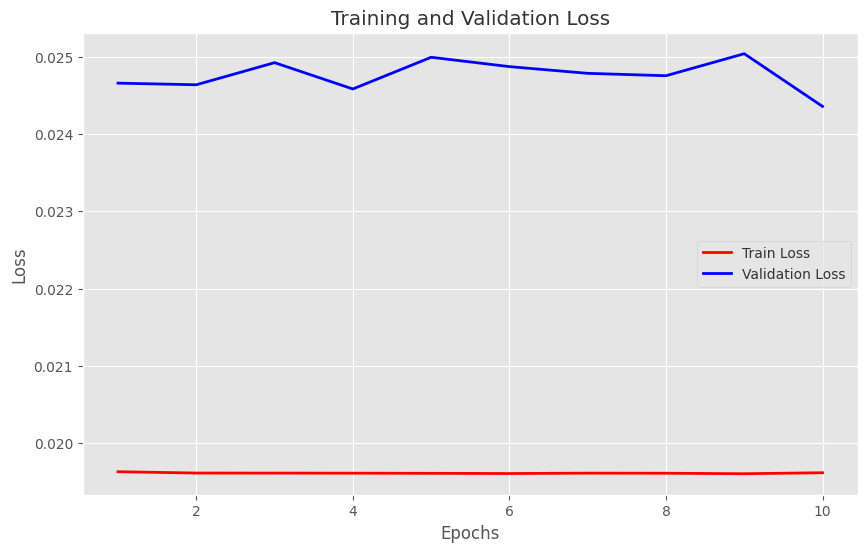


Running experiment with optimizer: Nadam, batch size: 32
Epoch 1/10 | Train Loss: 0.0196 | Validation Loss: 0.0245
Epoch 2/10 | Train Loss: 0.0196 | Validation Loss: 0.0247
Epoch 3/10 | Train Loss: 0.0196 | Validation Loss: 0.0245
Epoch 4/10 | Train Loss: 0.0196 | Validation Loss: 0.0247
Epoch 5/10 | Train Loss: 0.0196 | Validation Loss: 0.0246
Epoch 6/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 7/10 | Train Loss: 0.0196 | Validation Loss: 0.0247
Epoch 8/10 | Train Loss: 0.0196 | Validation Loss: 0.0247
Epoch 9/10 | Train Loss: 0.0196 | Validation Loss: 0.0248
Epoch 10/10 | Train Loss: 0.0196 | Validation Loss: 0.0247


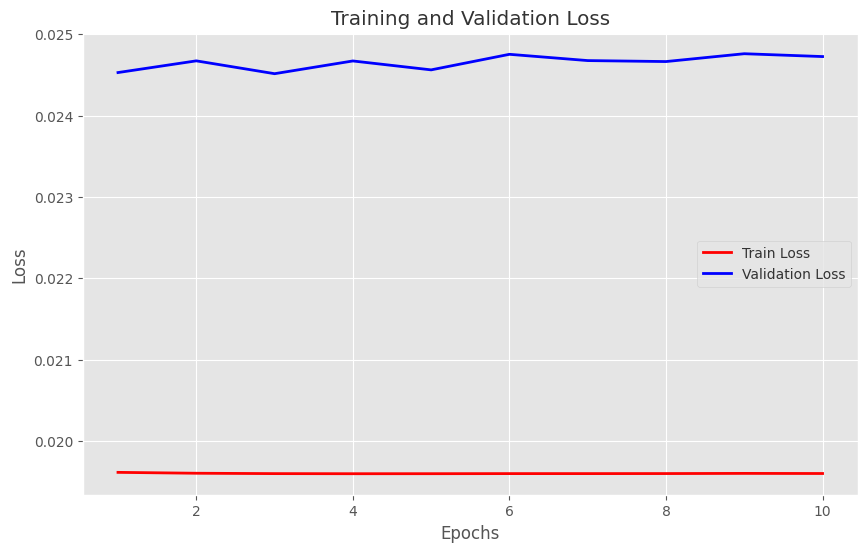

In [16]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

# Define the device (use 'cuda' if GPU is available, otherwise use 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the correct device
model = SimpleCNN().to(device)  # Ensure the model is on the correct device (CPU or GPU)

# Ensure the loss function is BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss()

# Experiment Loop for Optimizers and Batch Sizes
optimizers = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Nadam']
batch_sizes = [8, 16, 32]

# Iterate through different optimizer and batch size configurations
for optimizer_name in optimizers:
    for batch_size in batch_sizes:
        print(f"\nRunning experiment with optimizer: {optimizer_name}, batch size: {batch_size}")
        
        # Update config for each experiment
        train_config['optimizer_type'] = optimizer_name
        train_config['batch_size'] = batch_size
        
        # Prepare dataloaders with the current batch size
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Choose the optimizer based on the optimizer name
        if optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters())
        elif optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        elif optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters())
        elif optimizer_name == 'Adagrad':
            optimizer = torch.optim.Adagrad(model.parameters())
        elif optimizer_name == 'Nadam':
            optimizer = torch.optim.NAdam(model.parameters())

        # Train the model with the current configuration
        model.train()  # Set the model to training mode
        train_epoch_losses = []
        val_epoch_losses = []

        for epoch in range(train_config['n_epochs']):
            # Training loop
            train_epoch_loss = 0
            for inputs, targets in train_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Modify targets before calculating loss: reshape to [batch_size, 1]
                targets = targets.mean(dim=(1, 2, 3))  # Average across spatial dimensions
                targets = targets.unsqueeze(1)  # Add the channel dimension for binary classification
                
                # Forward pass
                optimizer.zero_grad()
                preds = model(inputs)  # Model's output will have shape [batch_size, 1]
                
                # Calculate the loss (now shapes should be compatible)
                train_batch_loss = loss_fn(preds, targets)
                train_epoch_loss += train_batch_loss.item()
                
                # Backward pass
                train_batch_loss.backward()
                optimizer.step()

            # Average training loss for this epoch
            train_epoch_loss /= len(train_dataloader)
            train_epoch_losses.append(train_epoch_loss)

            # Validation loop
            model.eval()  # Set the model to evaluation mode
            val_epoch_loss = 0
            with torch.no_grad():
                for inputs, targets in val_dataloader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    # Modify targets before calculating loss
                    targets = targets.mean(dim=(1, 2, 3))  # Average across spatial dimensions
                    targets = targets.unsqueeze(1)  # Add the channel dimension for binary classification
                    
                    preds = model(inputs)  # Model's output will have shape [batch_size, 1]
                    val_batch_loss = loss_fn(preds, targets)
                    val_epoch_loss += val_batch_loss.item()

            # Average validation loss for this epoch
            val_epoch_loss /= len(val_dataloader)
            val_epoch_losses.append(val_epoch_loss)

            # Print epoch loss for training and validation
            print(f"Epoch {epoch+1}/{train_config['n_epochs']} | "
                  f"Train Loss: {train_epoch_loss:.4f} | "
                  f"Validation Loss: {val_epoch_loss:.4f}")

        # Plot learning curves for the current configuration
        plot_learning_curves(train_epoch_losses, val_epoch_losses)


Confusion Matrix:
[[8]]
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


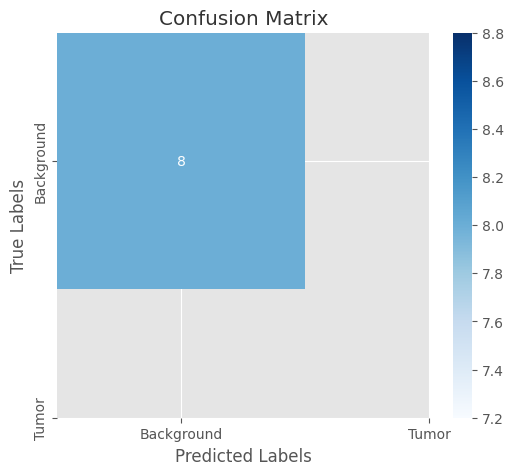

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def compute_metrics(preds, targets):
    # Binarize the predictions (for binary classification, threshold at 0.5)
    preds = (preds > 0.5).float()  # Convert probabilities to 0 or 1 (binary classification)

    # If targets are not binary, binarize them as well (threshold at 0.5)
    targets = (targets > 0.5).float()  # Convert to binary (0 or 1)
    
    # Flatten the tensors to 1D for comparison (ignoring the batch dimension)
    preds = preds.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()

    # Compute Confusion Matrix
    cm = confusion_matrix(targets, preds)

    # Calculate Precision, Recall, and F1-Score
    precision = precision_score(targets, preds, average='binary')  # For binary classification
    recall = recall_score(targets, preds, average='binary')       # For binary classification
    f1 = f1_score(targets, preds, average='binary')               # For binary classification

    # Print the metrics
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm)

def plot_confusion_matrix(cm, classes=['Background', 'Tumor']):
    """
    Plot confusion matrix using a heatmap.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example usage (preds, targets are model outputs and ground truth respectively):
# preds = torch.sigmoid(model(inputs))  # Get the output from the model
# preds = (preds > 0.5).float()  # Binarize predictions (for binary segmentation)

# Example targets could also need to be binarized if not already in binary format:
# targets = (targets > 0.5).float()

# Compute metrics
compute_metrics(preds, targets)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Confusion Matrix:
 [[8 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Class 0: Precision = 1.0000, Recall = 1.0000, F1-Score = 1.0000
Class 1: Precision = 0.0000, Recall = 0.0000, F1-Score = 0.0000
Class 2: Precision = 0.0000, Recall = 0.0000, F1-Score = 0.0000
Class 3: Precision = 0.0000, Recall = 0.0000, F1-Score = 0.0000


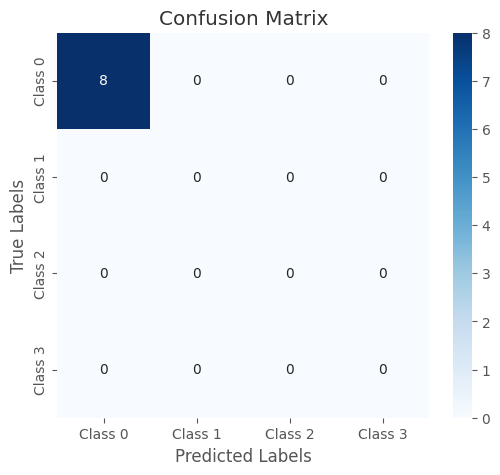

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def compute_metrics_multi_class(preds, targets, num_classes=4):
    # Apply argmax to get class labels for multi-class segmentation (discretizing the predictions)
    preds = preds.argmax(dim=1)  # Get class labels (for multi-class segmentation)

    # Ensure that targets are in discrete class label format (0, 1, 2, ...)
    targets = targets.argmax(dim=1)  # If targets are one-hot encoded, convert to class labels

    # Flatten the tensors to 1D for comparison (ignoring the batch dimension)
    preds = preds.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()

    # Compute Confusion Matrix
    cm = confusion_matrix(targets, preds, labels=np.arange(num_classes))

    # Calculate Precision, Recall, and F1-Score for each class
    precision = precision_score(targets, preds, average=None, labels=np.arange(num_classes))
    recall = recall_score(targets, preds, average=None, labels=np.arange(num_classes))
    f1 = f1_score(targets, preds, average=None, labels=np.arange(num_classes))

    # Print the metrics for each class
    print("Confusion Matrix:\n", cm)
    for i in range(num_classes):
        print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1-Score = {f1[i]:.4f}")

    # Plot the confusion matrix
    plot_confusion_matrix(cm, classes=[f"Class {i}" for i in range(num_classes)])

def plot_confusion_matrix(cm, classes=['Class 0', 'Class 1', 'Class 2', 'Class 3']):
    """
    Plot confusion matrix using a heatmap.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example usage for multi-class:
# preds = model(inputs)  # Get the output from the model (raw logits or after softmax)
# preds = preds.argmax(dim=1)  # Get class labels (for multi-class segmentation)

# Compute metrics for multi-class
compute_metrics_multi_class(preds, targets, num_classes=4)


## **Create Dataloader and Train the Model**

In [15]:
# Ensure you import necessary libraries and modules
import torch
from torch.utils.data import DataLoader

# Define the device (use 'cuda' if GPU is available, otherwise use 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the correct device
model = SimpleCNN().to(device)  # Ensure the model is on the correct device (CPU or GPU)

# Experiment Loop for Optimizers and Batch Sizes
optimizers = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Nadam']
batch_sizes = [8, 16, 32]

# Iterate through different optimizer and batch size configurations
for optimizer in optimizers:
    for batch_size in batch_sizes:
        print(f"\nRunning experiment with optimizer: {optimizer}, batch size: {batch_size}")
        
        # Update config for each experiment
        train_config['optimizer_type'] = optimizer
        train_config['batch_size'] = batch_size
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Train the model with the current configuration
        train_epoch_losses, val_epoch_losses = train_with_diff_configs(model, train_dataloader, val_dataloader, train_config, verbose=False)
        
        # Plot learning curves for the current configuration
        plot_learning_curves(train_epoch_losses, val_epoch_losses)



Running experiment with optimizer: Adam, batch size: 8


NameError: name 'train_with_diff_configs' is not defined

## **Define Plot Learning Curves**

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot([np.NaN] + train_epoch_losses, label="Train Loss", color='r', linewidth=2)
    ax.plot([np.NaN] + val_epoch_losses, label="Validation Loss", color='b', linewidth=2)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()

    plt.show()


# With Adam

In [ ]:
# # Create dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# # Train model
# train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

In [ ]:
# def plot_learning_curves(train_epoch_losses, val_epoch_losses):
#     plt.style.use('ggplot')
#     plt.rcParams['text.color'] = '#333333'

#     fig, axis = plt.subplots(1, 1, figsize=(10, 6))

#     # Plot training and validation loss (NaN is used to offset epochs by 1)
#     axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
#     axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

#     # Adding title, labels and formatting
#     axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
#     axis.set_xlabel('Epoch', fontsize=14)
#     axis.set_ylabel('Loss', fontsize=14)

#     axis.set_ylim(0, 1)
    
#     axis.legend(fontsize=12)
#     axis.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.show()
    
# plot_learning_curves(train_epoch_losses, val_epoch_losses)

In [13]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

NameError: name 'test_input_iterator' is not defined

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    """
    Plots the training and validation loss curves over epochs.

    Parameters:
    - train_epoch_losses (list): List of training loss values for each epoch.
    - val_epoch_losses (list): List of validation loss values for each epoch.
    """
    # Set plot style
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax.plot(
        [np.NaN] + train_epoch_losses, 
        color='#636EFA', 
        marker='o', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Training Loss'
    )
    ax.plot(
        [np.NaN] + val_epoch_losses, 
        color='#EFA363', 
        marker='s', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Validation Loss'
    )

    # Add title, labels, legend, and grid
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_ylim(0, max(max(train_epoch_losses), max(val_epoch_losses)) * 1.1)  # Dynamic y-axis
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


plot_learning_curves(train_epoch_losses, val_epoch_losses)


NameError: name 'train_epoch_losses' is not defined

## EI PORJONTO HOICHE

# With SGD

In [ ]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        64,
    'learning_rate':     0.001,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1,
    'optimizer_type': 'SGD'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model = UNet(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# Count parameters
count_parameters(model)

# Move model to device
device = torch.device(train_config['device'])
model = model.to(device)

In [ ]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

In [ ]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    """
    Plots the training and validation loss curves over epochs.

    Parameters:
    - train_epoch_losses (list): List of training loss values for each epoch.
    - val_epoch_losses (list): List of validation loss values for each epoch.
    """
    # Set plot style
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax.plot(
        [np.NaN] + train_epoch_losses, 
        color='#636EFA', 
        marker='o', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Training Loss'
    )
    ax.plot(
        [np.NaN] + val_epoch_losses, 
        color='#EFA363', 
        marker='s', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Validation Loss'
    )

    # Add title, labels, legend, and grid
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_ylim(0, max(max(train_epoch_losses), max(val_epoch_losses)) * 1.1)  # Dynamic y-axis
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


plot_learning_curves(train_epoch_losses, val_epoch_losses)


# Unet with Dropout

In [ ]:
from torch import nn 
def encoder_block_drop(in_channels, out_channels, activation=nn.ReLU(), drop_out_rate=0.5):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Dropout(p=drop_out_rate),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

def decoder_block_drop(in_channels, out_channels, activation=nn.ReLU(), drop_out_rate=0.5):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Dropout(p=drop_out_rate),
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

In [ ]:
class UNet_Drop(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU(), drop_out_rate=0.5):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet_Drop, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block_drop(in_channels, 1 * n_filters, activation, drop_out_rate)
        self.enc2 = encoder_block_drop(1 * n_filters, 2 * n_filters, activation, drop_out_rate)
        self.enc3 = encoder_block_drop(2 * n_filters, 4 * n_filters, activation, drop_out_rate)
        self.enc4 = encoder_block_drop(4 * n_filters, 8 * n_filters, activation, drop_out_rate)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8 * n_filters, 16 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Dropout(p=drop_out_rate),
            nn.Conv2d(16 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec4 = decoder_block_drop(16 * n_filters, 4 * n_filters, activation, drop_out_rate)
        self.dec3 = decoder_block_drop(8 * n_filters, 2 * n_filters, activation, drop_out_rate)
        self.dec2 = decoder_block_drop(4 * n_filters, 1 * n_filters, activation, drop_out_rate)
        self.dec1 = decoder_block_drop(2 * n_filters, 1 * n_filters, activation, drop_out_rate)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder pathway with skip connections
        dec4 = self.dec4(torch.cat([self.upsample(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upsample(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

In [ ]:
drop_train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        32,
    'learning_rate':     0.001,
    'batches_per_epoch': 32,
    'lr_decay_factor':   1,
    'optimizer_type': 'Nadam'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model_drop = UNet_Drop(in_channels=4, out_channels=3, n_filters=32, activation=activation_function, drop_out_rate=0.3)

# Count parameters
count_parameters(model_drop)

# Move model to device
device = torch.device(drop_train_config['device'])
model_drop = model_drop.to(device)

In [ ]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=drop_train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=drop_train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model_drop, train_dataloader, val_dataloader, drop_train_config, verbose=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    """
    Plots the training and validation loss curves over epochs.

    Parameters:
    - train_epoch_losses (list): List of training loss values for each epoch.
    - val_epoch_losses (list): List of validation loss values for each epoch.
    """
    # Set plot style
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax.plot(
        [np.NaN] + train_epoch_losses, 
        color='#636EFA', 
        marker='o', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Training Loss'
    )
    ax.plot(
        [np.NaN] + val_epoch_losses, 
        color='#EFA363', 
        marker='s', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Validation Loss'
    )

    # Add title, labels, legend, and grid
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_ylim(0, max(max(train_epoch_losses), max(val_epoch_losses)) * 1.1)  # Dynamic y-axis
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


plot_learning_curves(train_epoch_losses, val_epoch_losses)


In [ ]:
print(model_drop)

# With Dense and Batch Normalization

In [ ]:
def encoder_block_batch(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        activation
    )

def decoder_block_batch(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_channels // 2), 
        activation,
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        activation
    )

In [ ]:
class UNet_Batch(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU()):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet_Batch, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block_drop(in_channels, 1 * n_filters, activation)
        self.enc2 = encoder_block_drop(1 * n_filters, 2 * n_filters, activation)
        self.enc3 = encoder_block_drop(2 * n_filters, 4 * n_filters, activation)
        self.enc4 = encoder_block_drop(4 * n_filters, 8 * n_filters, activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8 * n_filters, 16 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Conv2d(16 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec4 = decoder_block_drop(16 * n_filters, 4 * n_filters, activation)
        self.dec3 = decoder_block_drop(8 * n_filters, 2 * n_filters, activation)
        self.dec2 = decoder_block_drop(4 * n_filters, 1 * n_filters, activation)
        self.dec1 = decoder_block_drop(2 * n_filters, 1 * n_filters, activation)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder pathway with skip connections
        dec4 = self.dec4(torch.cat([self.upsample(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upsample(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

In [ ]:
batch_train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        64,
    'learning_rate':     0.001,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1,
    'optimizer_type': 'Nadam'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model_batch = UNet_Batch(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# Count parameters
count_parameters(model_batch)

# Move model to device
device = torch.device(batch_train_config['device'])
model_batch = model_batch.to(device)

In [ ]:
print(model_drop_dense)

In [ ]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=dense_drop_train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=dense_drop_train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model_drop_dense, train_dataloader, val_dataloader, dense_drop_train_config, verbose=False)